<a href="https://colab.research.google.com/github/YasinnSoylu/Breast-Cancer-Classification-KERS-PYTORCH/blob/main/KERAS_TRANSFER_LEARN%C4%B0NG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
! pip install -q kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d paultimothymooney/breast-histopathology-images
!unzip breast-histopathology-images.zip


In [32]:
#import neccessary Libraries and modules
import pandas as pd
import numpy as np
import os
from glob import glob
import random
import matplotlib.pylab as plt

from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
import keras.backend as K

from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import SGD, RMSprop, Adam, Adagrad, Adadelta
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPool2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [3]:
imagePatches = glob('/content/IDC_regular_ps50_idx5/**/*.png', recursive=True)
for filename in imagePatches[0:10]:
    print(filename)

/content/IDC_regular_ps50_idx5/8984/1/8984_idx5_x2251_y1751_class1.png
/content/IDC_regular_ps50_idx5/8984/1/8984_idx5_x2651_y1151_class1.png
/content/IDC_regular_ps50_idx5/8984/1/8984_idx5_x2801_y1201_class1.png
/content/IDC_regular_ps50_idx5/8984/1/8984_idx5_x2801_y1301_class1.png
/content/IDC_regular_ps50_idx5/8984/1/8984_idx5_x2351_y1251_class1.png
/content/IDC_regular_ps50_idx5/8984/1/8984_idx5_x1901_y1401_class1.png
/content/IDC_regular_ps50_idx5/8984/1/8984_idx5_x1951_y1401_class1.png
/content/IDC_regular_ps50_idx5/8984/1/8984_idx5_x2051_y1801_class1.png
/content/IDC_regular_ps50_idx5/8984/1/8984_idx5_x1901_y1501_class1.png
/content/IDC_regular_ps50_idx5/8984/1/8984_idx5_x2351_y1201_class1.png


In [4]:
# Two arrays holding images by class type

class0 = [] # 0 = no cancer
class1 = [] # 1 = cancer

for filename in imagePatches:
    if filename.endswith("class0.png"):
         class0.append(filename)
    else:
        class1.append(filename)

In [5]:
print("class 0 :",len(class0))
print("class 1 :",len(class1))


class 0 : 198738
class 1 : 78786


In [6]:
sampled_class0 = random.sample(class0, 10000)
sampled_class1 = random.sample(class1, 10000)
#len(sampled_class0)

In [7]:
from matplotlib.image import imread
import cv2

def get_image_arrays(data, label):
    img_arrays = []
    for i in data:
        if i.endswith('.png'):
            img = cv2.imread(i ,cv2.IMREAD_COLOR)
            img_sized = cv2.resize(img, (128, 128), interpolation=cv2.INTER_LINEAR)
            img_arrays.append([img_sized, label])
    return img_arrays

In [8]:
class0_array = get_image_arrays(sampled_class0, 0)
class1_array = get_image_arrays(sampled_class1, 1)

In [9]:
def show_img(files):
    plt.figure(figsize= (10,10))
    ind = np.random.randint(0, len(files), 25)
    i=0
    for loc in ind:
        plt.subplot(5,5,i+1)
        sample = load_img(files[loc], target_size=(150,150))
        sample = img_to_array(sample)
        plt.axis("off")
        plt.imshow(sample.astype("uint8"))
        i+=1

In [10]:
combined_data = np.concatenate((class0_array, class1_array))
random.seed(42)
random.shuffle(combined_data)

In [11]:
X = []
y = []

for features,label in combined_data:
    X.append(features)
    y.append(label)

In [12]:
X = np.array(X).reshape(-1, 128, 128,3)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(15000, 128, 128, 3) (5000, 128, 128, 3) (15000, 2) (5000, 2)


In [14]:
base_model = tf.keras.applications.VGG16(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(128, 128, 3),
    include_top=False)


In [15]:
for layer in base_model.layers[:-1]:
    layer.trainable=False

In [16]:
model=Sequential()
model.add(base_model)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(2,activation='softmax'))


In [17]:
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 dropout (Dropout)           (None, 4, 4, 512)         0         
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 2)                 16386     
                                                                 
Total params: 14,731,074
Trainable params: 16,386
Non-trainable params: 14,714,688
_________________________________________________________________


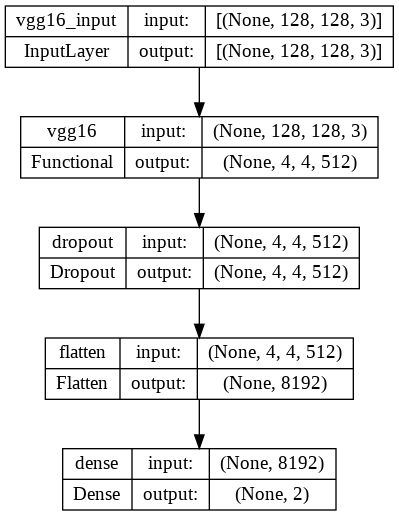

In [18]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image
plot_model(model, to_file='convnet.png', show_shapes=True,show_layer_names=True)
Image(filename='convnet.png') 

In [34]:
model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])

In [35]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
lrd = ReduceLROnPlateau(monitor = 'val_loss',patience = 5,verbose = 1,factor = 0.75, min_lr = 1e-10)
mcp = ModelCheckpoint('model.h5')

In [36]:
%time
history=model.fit(X_train, y_train,validation_data=(X_test, y_test),verbose = 1,epochs = 10,callbacks=[lrd,mcp,es])

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 8.11 µs
Epoch 1/10
469/469 [==============================] - 32s 67ms/step - loss: 2.1117 - accuracy: 0.8820 - val_loss: 2.1037 - val_accuracy: 0.9078 - lr: 0.0010
Epoch 2/10
469/469 [==============================] - 32s 68ms/step - loss: 2.0961 - accuracy: 0.8857 - val_loss: 2.1118 - val_accuracy: 0.8996 - lr: 0.0010
Epoch 3/10
469/469 [==============================] - 32s 68ms/step - loss: 2.0944 - accuracy: 0.8875 - val_loss: 1.9565 - val_accuracy: 0.9026 - lr: 0.0010
Epoch 4/10
469/469 [==============================] - 32s 69ms/step - loss: 2.1108 - accuracy: 0.8883 - val_loss: 2.4126 - val_accuracy: 0.9026 - lr: 0.0010
Epoch 5/10
469/469 [==============================] - 33s 70ms/step - loss: 2.1282 - accuracy: 0.8913 - val_loss: 2.0730 - val_accuracy: 0.9018 - lr: 0.0010
Epoch 6/10
469/469 [==============================] - 32s 69ms/step - loss: 1.9876 - accuracy: 0.8937 - val_loss: 2.1226 - val_accuracy: 0.9070 - l

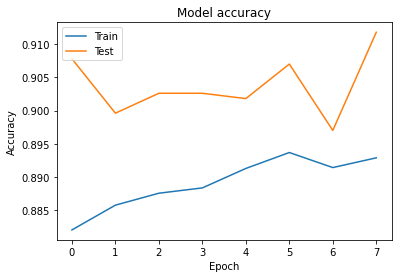

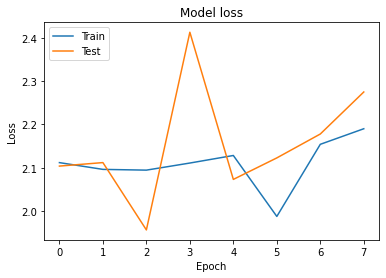

In [37]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot loss values vs epoch
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()